- Implement ARIMA/SARIMA models for forecasting Bitcoin prices.
  - Perform grid search to optimize ARIMA parameters (p, d, q).
  - Detect seasonality and incorporate SARIMA if needed.
- Explore the use of Prophet model for capturing trends and seasonality.
  - Implement the Prophet model.
  - Capture holiday effects and seasonality with weekly or daily data.
- Utilize Long Short-Term Memory (LSTM) networks for deep learning predictions.
  - Set up an LSTM network to capture long-term dependencies in Bitcoin trends.
  - Train LSTM models on historical data.
- Implement DTW to measure similarities between time series.
- Cluster Bitcoin data based on movement to uncover trends or patterns (e.g., bull vs. bear periods).
- Incorporate GARCH models to estimate and forecast volatility of Bitcoin prices.
- Set up a Reinforcement Learning (RL) agent to optimize buy/sell decisions.
- Implement Deep Q-Networks (DQN) or Policy Gradient methods for trading.
- Train the RL agent with Bitcoin data to maximize profit based on reward signals.

## Loading the dataset

In [ ]:
import yfinance as yf

BTC = yf.Ticker("BTC-GBP")
print("Bitcoin Current : ", round(BTC.info['open'],0))
print("        Day     : ", round(BTC.info['dayLow'], 0), "-", round(BTC.info['dayHigh'], 0))
print("        52 Week : ", round(BTC.info['fiftyTwoWeekLow'], 0), "-", round(BTC.info['fiftyTwoWeekHigh'], 0))

Bitcoin Current :  47458.0
        Day     :  47178.0 - 47616.0
        52 Week :  21287.0 - 57649.0


In [ ]:
print(BTC)

yfinance.Ticker object <BTC-GBP>


In [ ]:
! pip install mplfinance

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import mplfinance as mpf
from datetime import date
import matplotlib.pyplot as plt
from datetime import datetime

ticker_symbol = 'BTC-USD'

data = yf.download(ticker_symbol, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
display(data.head())
display(data.tail())

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-15,60000.726562,60381.917969,58696.308594,59182.835938,59182.835938,18120960867
2024-09-16,59185.226562,59205.511719,57501.339844,58192.507812,58192.507812,32032822113
2024-09-17,58192.507812,61316.089844,57628.070312,60308.539062,60308.539062,38075570118
2024-09-18,60309.000000,61664.066406,59218.253906,61649.679688,61649.679688,40990702891
2024-09-19,61651.156250,63872.441406,61609.867188,62940.457031,62940.457031,42710252573


Data dictionary


- **Date**: The trading date in YYYY-MM-DD format.
- **Open**: The price of Bitcoin at the start of the trading day.
- **High**: The highest price of Bitcoin during the trading day.
- **Low**: The lowest price of Bitcoin during the trading day.
- **Close**: The price of Bitcoin at the end of the trading day.
- **Adj Close**: The adjusted closing price of Bitcoin after accounting for dividends and splits (usually the same as the Close price for Bitcoin).
- **Volume**: The number of Bitcoin units traded during the trading day.


In [ ]:
print(date.today().strftime('%Y-%m-%d'))

2024-09-21


## Cleaning the Data

In [ ]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
data.dtypes

,0
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
# Date is an index, so wanted to included that as a column, thus resetting the index
data.reset_index(inplace = True)

In [ ]:
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
data.duplicated().sum()
# no duplicates

0

Text(0.5, 1.0, 'Boxplots for all the columns in the dataset')

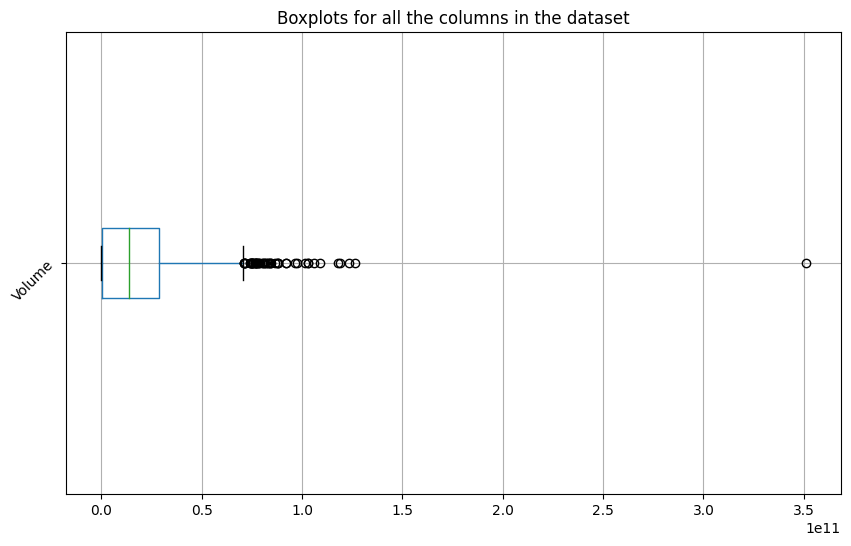

In [ ]:
# checking for outliers
data.boxplot(column = ['Volume'],figsize = (10,6) , rot = 45, vert = False)
plt.title('Boxplots for all the columns in the dataset')

# volumn has lot of outliers, Let's if they have any impact later on.
# need to investigate further for unusual drops and spikes

In [ ]:
# no unusual conditions
error_rows = []
for index, row in data.iterrows():
  if row['High'] < row['Low']:
    error_rows.append(index)

print(error_rows)

[]


In [ ]:
# assigning days to the dates, and week no. and also separating columns by month, and year
import datetime as dt

# Day of the week as an integer (0=Monday, 6=Sunday)
data['Day'] = data['Date'].dt.weekday

data['Week'] = data.Date.dt.isocalendar().week
# Month as an integer (1=January, 12=December)
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year
display(data.head())


,Date,Open,High,Low,Close,Adj Close,Volume,Day,Week,Month,Year
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2,38,9,2014
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,3,38,9,2014
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,4,38,9,2014
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,5,38,9,2014
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,6,38,9,2014


In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Day',
       'Week', 'Month', 'Year'],
      dtype='object')

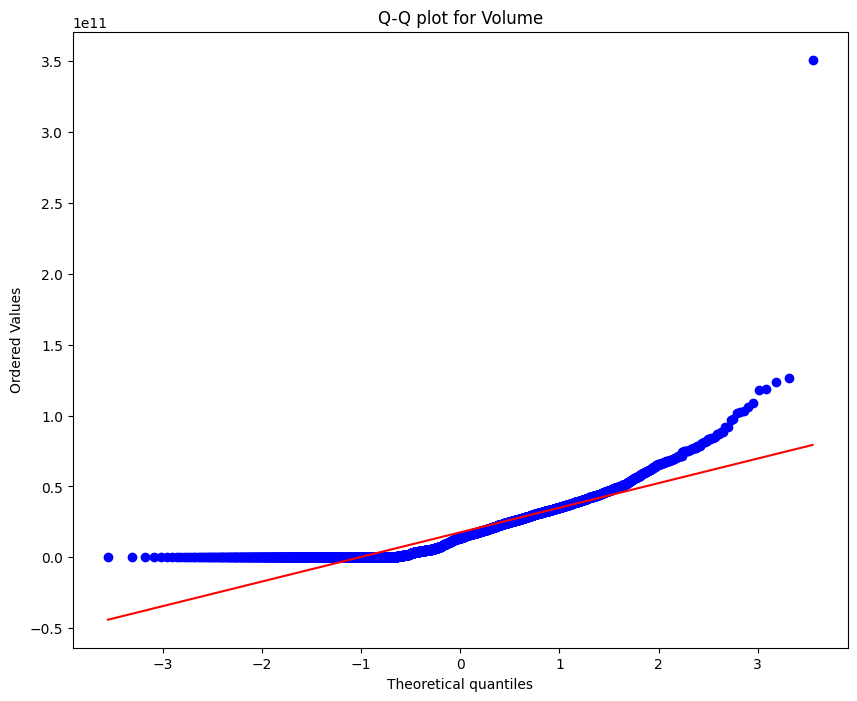

In [ ]:
# creating a q-q plot to check the skewness

import scipy.stats as stats

plt.figure(figsize=(10,8))
stats.probplot(data['Volume'], dist = 'norm',plot = plt)
plt.title('Q-Q plot for Volume')
plt.show()

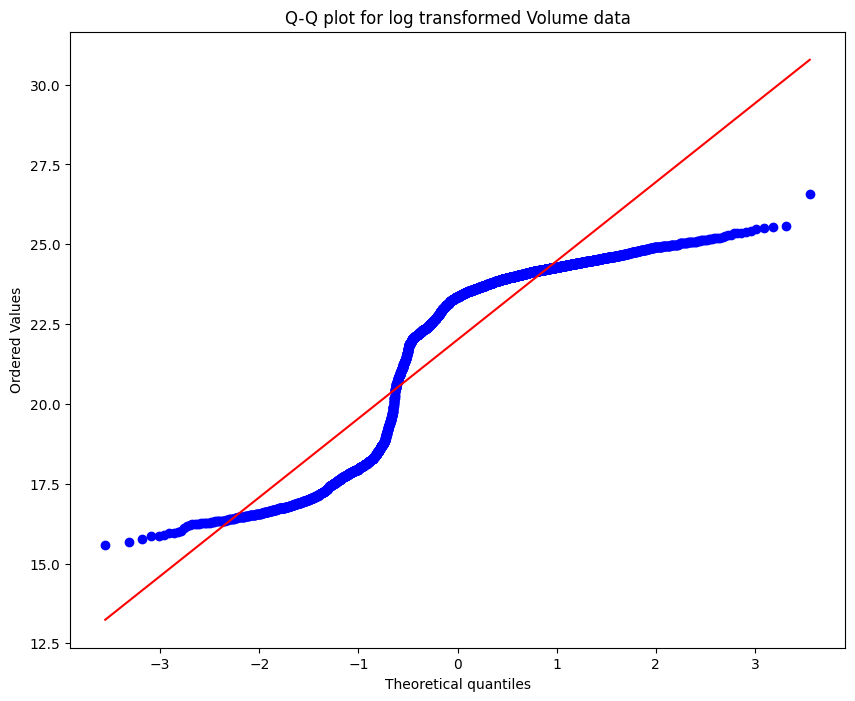

In [ ]:
import numpy as np

log_transformerd = np.log(data['Volume'])
data['Log Transformed Volume'] = log_transformerd
plt.figure(figsize = (10,8))
stats.probplot(log_transformerd,dist= 'norm',plot = plt)
plt.title('Q-Q plot for log transformed Volume data')
plt.show()

## 2. Data Visualisation

<Axes: >

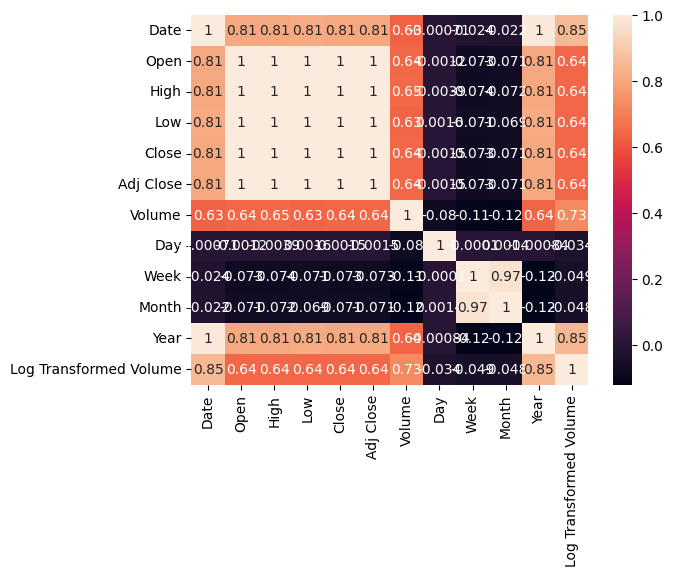

In [ ]:
import seaborn as sns

corr = data.corr()
sns.heatmap(corr, annot = True)


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


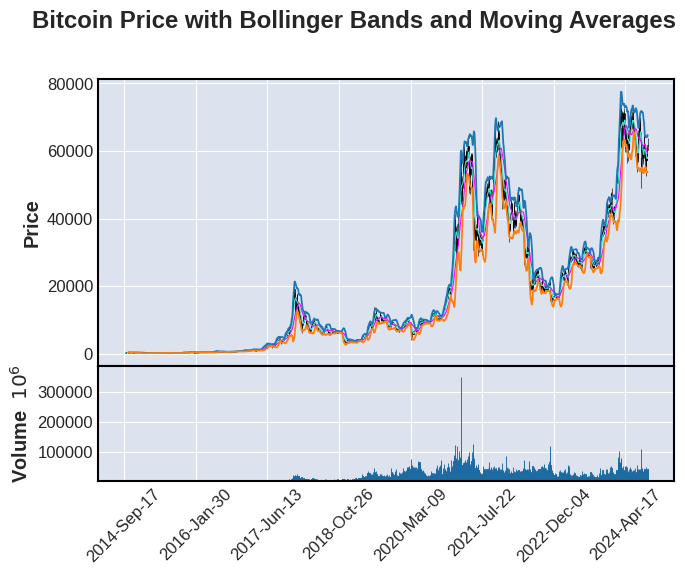

In [ ]:
import pandas as pd
import mplfinance as mpf

df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['SMA20'] = df['Close'].rolling(window=30).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()

df['Upper_BB'] = df['SMA20'] + (df['Close'].rolling(window=30).std() * 2)
df['Lower_BB'] = df['SMA20'] - (df['Close'].rolling(window=30).std() * 2)

mpf.plot(df, type='candle', mav=(20,50),
         addplot=[mpf.make_addplot(df['Upper_BB']),
                  mpf.make_addplot(df['Lower_BB'])],
         volume=True,
          title='Bitcoin Price with Bollinger Bands and Moving Averages')


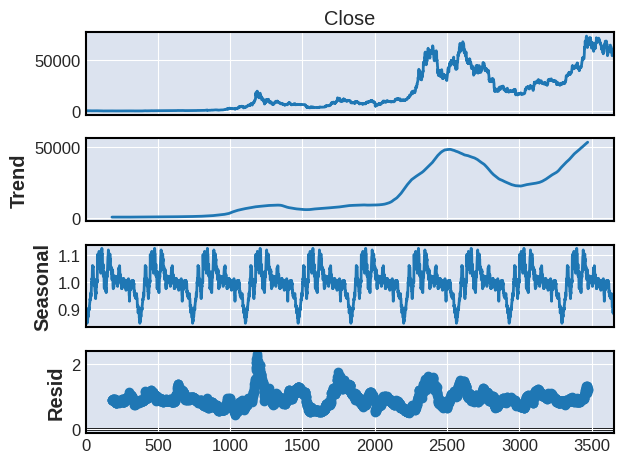

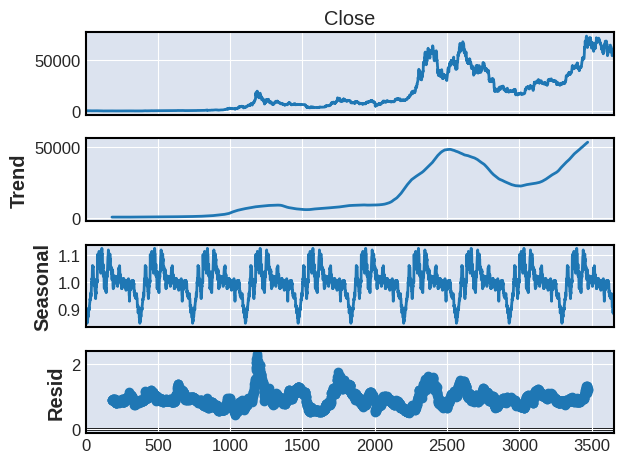

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model = 'multiplicative', period = 365)
result.plot()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
             open=df['Open'],
             high=df['High'],
             low=df['Low'],
             close=df['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


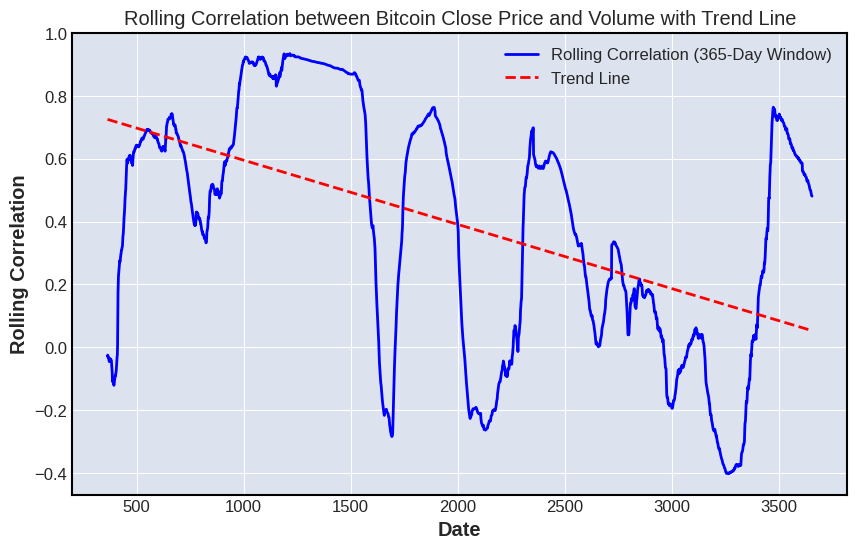

In [ ]:
rolling_corr = data['Close'].rolling(window=365).corr(data['Volume'])
rolling_corr = rolling_corr.dropna()

plt.figure(figsize=(10, 6))
sns.lineplot(data=rolling_corr, color='blue', label='Rolling Correlation (365-Day Window)')

x_values = np.arange(len(rolling_corr))
y_values = rolling_corr.values
slope, intercept = np.polyfit(x_values, y_values, 1)
trend_line = slope * x_values + intercept

plt.plot(rolling_corr.index, trend_line, color='red', linestyle='--', label='Trend Line')

plt.title('Rolling Correlation between Bitcoin Close Price and Volume with Trend Line')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.grid(True)
plt.legend()

plt.show()

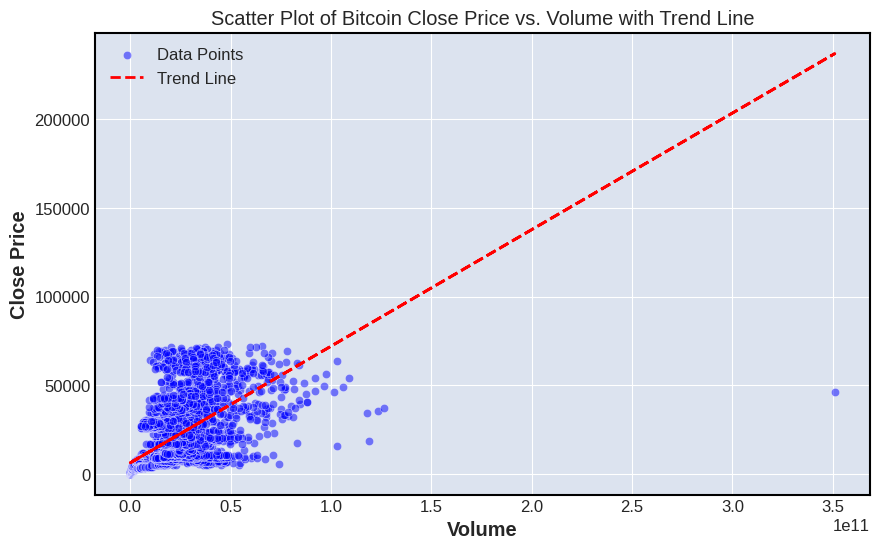

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Volume'], y=data['Close'], color='blue', alpha=0.5, label='Data Points')

slope, intercept = np.polyfit(data['Volume'], data['Close'], 1)
trend_line = slope * data['Volume'] + intercept

plt.plot(data['Volume'], trend_line, color='red', linestyle='--', label='Trend Line')

plt.title('Scatter Plot of Bitcoin Close Price vs. Volume with Trend Line')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()

plt.show()

## 3. Forcasting the closing price using ML models

1. ARIMA
2. PROPHET
3. LSTM

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Day', 'Week',
       'Month', 'Year', 'Log Transformed Volume'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



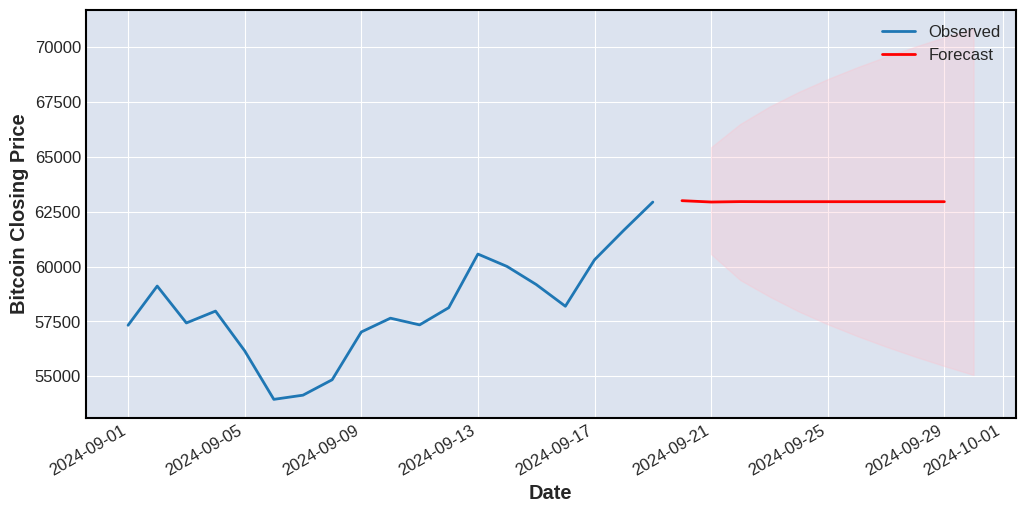

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

september_data = data.loc['2024-09-01':'2024-09-30']

mod = ARIMA(september_data['Close'], order=(2,1,1))
res = mod.fit()

forecast = res.get_forecast(steps=10)
forecast_index = pd.date_range(start='2024-09-21', periods=10, freq='D')

forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(september_data['Close'], label='Observed')
forecast_mean.plot(ax=ax, label='Forecast', color='r')
ax.fill_between(forecast_index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Closing Price')
ax.legend()

plt.show()

#try auto arima
# testing and train and compare which model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

<ipython-input-48-a3e298bf4999>:18: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead



ValueError: operands could not be broadcast together with shapes (10,) (3,) 

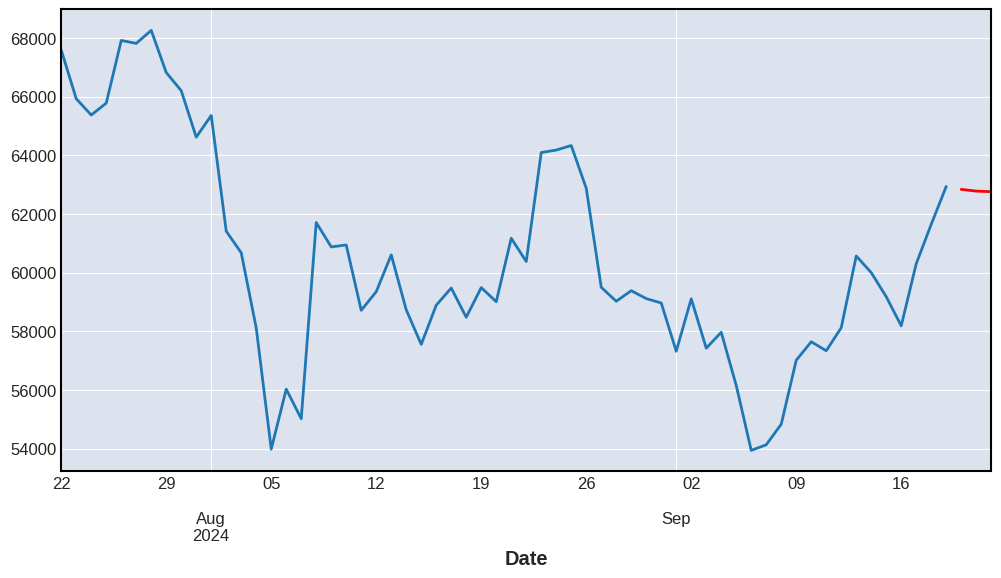

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd


mod = SARIMAX(data['Close'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
res = mod.fit()


forecast = res.get_forecast(steps=3)
forecast_index = pd.date_range(start=pd.to_datetime('today'), periods=10, freq='D')

forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

fig, ax = plt.subplots(figsize=(12, 6))

data_past_60_days = data['Close'].last('60D')
data_past_60_days.plot(ax=ax, label='Observed')

forecast_mean.plot(ax=ax, label='3-Day Forecast', color='r')
ax.fill_between(forecast_index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Closing Price')
ax.legend()

plt.show()
